# Dataset Exploration (PlantVillage)
This notebook is used to **explore the PlantVillage dataset** after preparation.
We will:
1. List all available classes.
2. Display a few example images to inspect quality.
3. Count how many images exist per class (class balance).
4. Decide whether data augmentation is needed.

In [8]:
from src import config
import random
import matplotlib.pyplot as plt
from PIL import Image

DATA_PROCESSED_DIR = config.DATA_PROCESSED_DIR
TRAIN_DIR = DATA_PROCESSED_DIR / "train"
VAL_DIR = DATA_PROCESSED_DIR / "val"

assert TRAIN_DIR.exists(), f"Train folder not found at: {TRAIN_DIR}. Please run 00_prepare_data.ipynb first."
print(f"Train dir: {TRAIN_DIR.resolve()}")

Train dir: C:\Users\Alexandre\PycharmProjects\MachineLearningProject\data\processed\train


## Step 1: List all classes
We list all subfolders in `data/processed/train`.
Each folder represents a separate class label.

In [9]:
classes = sorted([p.name for p in TRAIN_DIR.iterdir() if p.is_dir()])
print(f"Detected {len(classes)} classes:")
for c in classes:
    print(" -", c)

Detected 15 classes:
 - Pepper__bell___Bacterial_spot
 - Pepper__bell___healthy
 - Potato___Early_blight
 - Potato___Late_blight
 - Potato___healthy
 - Tomato_Bacterial_spot
 - Tomato_Early_blight
 - Tomato_Late_blight
 - Tomato_Leaf_Mold
 - Tomato_Septoria_leaf_spot
 - Tomato_Spider_mites_Two_spotted_spider_mite
 - Tomato__Target_Spot
 - Tomato__Tomato_YellowLeaf__Curl_Virus
 - Tomato__Tomato_mosaic_virus
 - Tomato_healthy


## Step 2: Display Sample Images
Let’s visualize a few samples per class to check:
* image readability
* labeling consistency
* potential corrupted or empty files

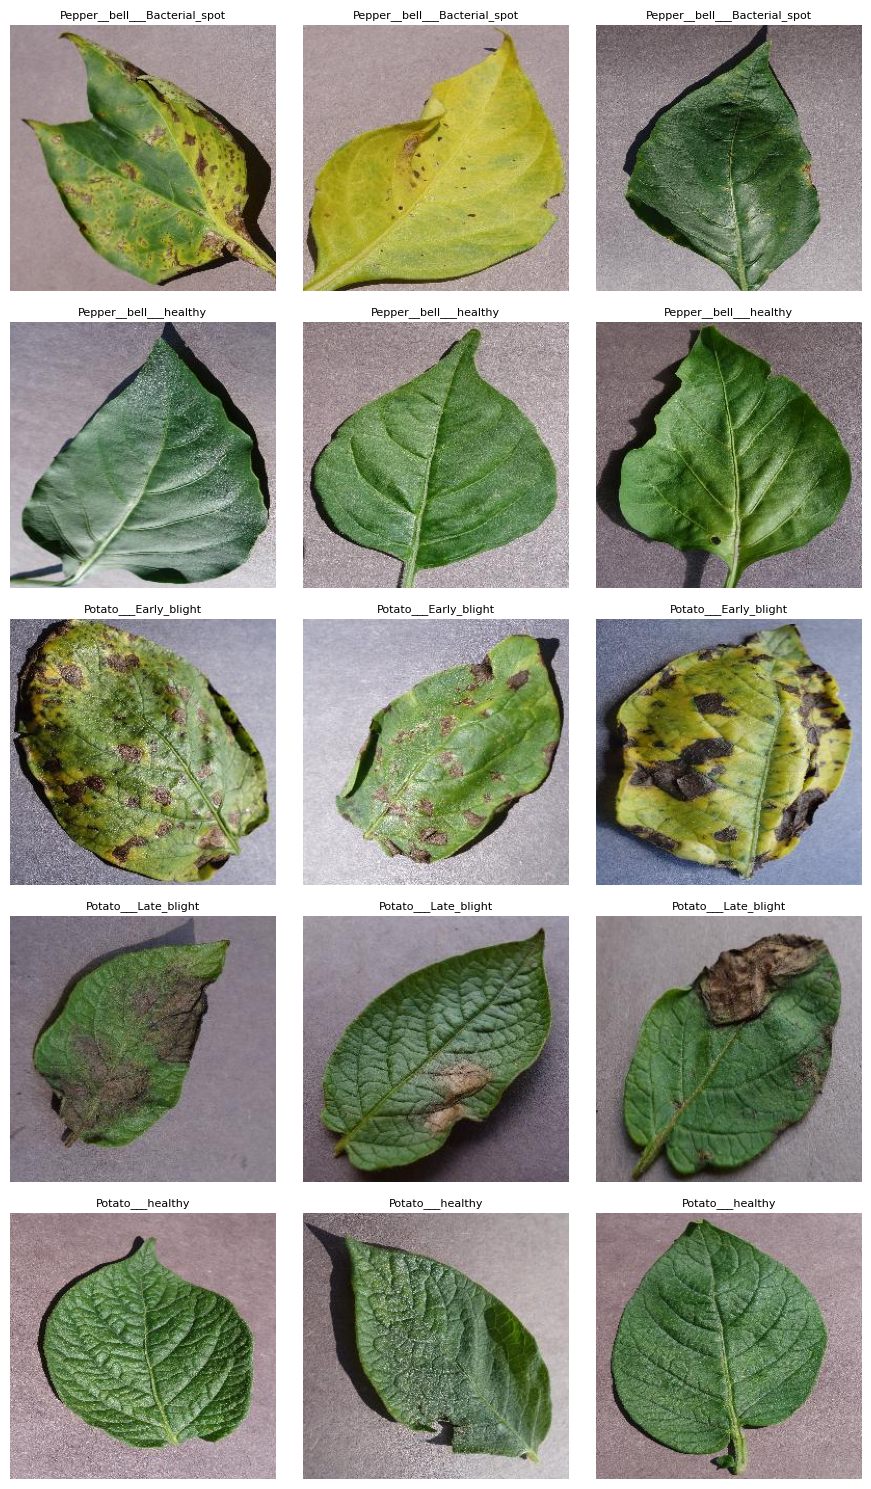

In [10]:
N_PER_CLASS = 3

MAX_CLASSES_TO_SHOW = 5
classes_to_show = classes[:MAX_CLASSES_TO_SHOW]

fig, axes = plt.subplots(len(classes_to_show), N_PER_CLASS, figsize=(N_PER_CLASS * 3, len(classes_to_show) * 3))

if len(classes_to_show) == 1:
    axes = [axes]

for i, cls in enumerate(classes_to_show):
    cls_dir = TRAIN_DIR / cls
    images = list(cls_dir.iterdir())
    images = [p for p in images if p.is_file()]
    random.shuffle(images)
    images = images[:N_PER_CLASS]

    for j in range(N_PER_CLASS):
        ax = axes[i][j] if len(classes_to_show) > 1 else axes[j]
        if j < len(images):
            try:
                img = Image.open(images[j])
            except Exception as e:
                print(f"Bad image: {images[j]} ({e})")
                ax.axis("off")
                continue
            ax.imshow(img)
            ax.set_title(cls, fontsize=8)
            ax.axis("off")
        else:
            ax.axis("off")

plt.tight_layout()
plt.show()

## Step 3: Count Images per Class

We count how many image files exist for each class in the training directory.
This helps identify imbalanced classes.

In [11]:
IMAGE_EXTS = (".jpg", ".jpeg", ".png", ".bmp")

class_counts = {}
for cls in classes:
    cls_dir = TRAIN_DIR / cls
    count = sum(1 for p in cls_dir.iterdir() if p.is_file() and p.suffix.lower() in IMAGE_EXTS)
    class_counts[cls] = count

for cls, count in sorted(class_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{cls:45s}: {count}")

Tomato__Tomato_YellowLeaf__Curl_Virus        : 2566
Tomato_Bacterial_spot                        : 1701
Tomato_Late_blight                           : 1527
Tomato_Septoria_leaf_spot                    : 1416
Tomato_Spider_mites_Two_spotted_spider_mite  : 1340
Tomato_healthy                               : 1272
Pepper__bell___healthy                       : 1182
Tomato__Target_Spot                          : 1123
Potato___Early_blight                        : 800
Potato___Late_blight                         : 800
Tomato_Early_blight                          : 800
Pepper__bell___Bacterial_spot                : 797
Tomato_Leaf_Mold                             : 761
Tomato__Tomato_mosaic_virus                  : 298
Potato___healthy                             : 121


### Visualize Class Balance

A simple bar chart gives an overview of the dataset distribution.

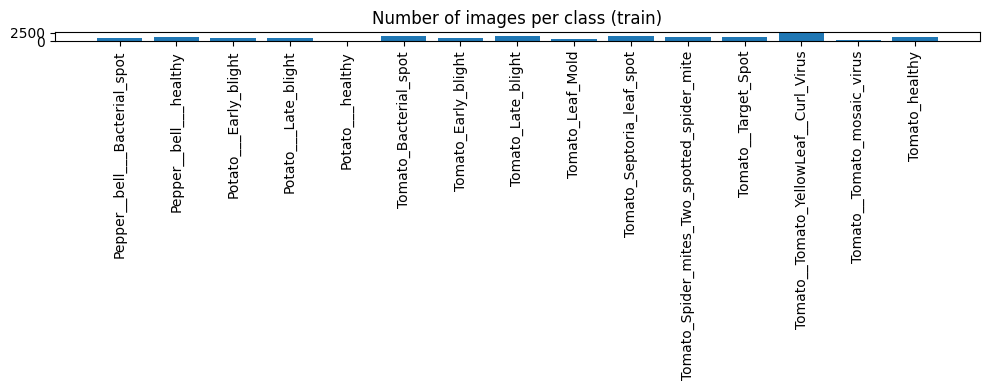

In [12]:
plt.figure(figsize=(10, 4))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90)
plt.title("Number of images per class (train)")
plt.tight_layout()
plt.show()

## Step 4: Decide on Data Augmentation Needs
* Take the largest class as reference.
* Any class with less than half that size may benefit from augmentation.

In [13]:
max_count = max(class_counts.values())
threshold = max_count / 2

underrepresented = [cls for cls, cnt in class_counts.items() if cnt < threshold]

print(f"Largest class: {max_count} images")
print(f"Threshold for 'low': {threshold:.0f} images\n")

if underrepresented:
    print("Classes that may benefit from data augmentation:")
    for cls in underrepresented:
        print(f" - {cls} ({class_counts[cls]} images)")
else:
    print("Dataset appears fairly balanced. You can still apply global augmentation to reduce overfitting.")

Largest class: 2566 images
Threshold for 'low': 1283 images

Classes that may benefit from data augmentation:
 - Pepper__bell___Bacterial_spot (797 images)
 - Pepper__bell___healthy (1182 images)
 - Potato___Early_blight (800 images)
 - Potato___Late_blight (800 images)
 - Potato___healthy (121 images)
 - Tomato_Early_blight (800 images)
 - Tomato_Leaf_Mold (761 images)
 - Tomato__Target_Spot (1123 images)
 - Tomato__Tomato_mosaic_virus (298 images)
 - Tomato_healthy (1272 images)


### Check Validation Folder
We can also check the number of validation images per class, just to ensure the split ratio looks consistent.

In [14]:
if VAL_DIR.exists():
    val_counts = {}
    for cls in classes:
        cls_dir = VAL_DIR / cls
        if not cls_dir.exists():
            continue
        count = sum(1 for p in cls_dir.iterdir() if p.is_file() and p.suffix.lower() in IMAGE_EXTS)
        val_counts[cls] = count

    print("\nValidation images per class:")
    for cls, count in sorted(val_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"{cls:45s}: {count}")


Validation images per class:
Tomato__Tomato_YellowLeaf__Curl_Virus        : 642
Tomato_Bacterial_spot                        : 426
Tomato_Late_blight                           : 382
Tomato_Septoria_leaf_spot                    : 355
Tomato_Spider_mites_Two_spotted_spider_mite  : 336
Tomato_healthy                               : 319
Pepper__bell___healthy                       : 296
Tomato__Target_Spot                          : 281
Pepper__bell___Bacterial_spot                : 200
Potato___Early_blight                        : 200
Potato___Late_blight                         : 200
Tomato_Early_blight                          : 200
Tomato_Leaf_Mold                             : 191
Tomato__Tomato_mosaic_virus                  : 75
Potato___healthy                             : 31
